In [ ]:
# ====================  Olsson-style MQAR benchmark  ====================
import torch, math, random, itertools
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ── hyper-params (paper-faithful) ───────────────────────────────────────
KV_PAIRS      = 16          # 16 K-V pairs  → 64 tokens
SEQ_LEN       = KV_PAIRS * 4
VOCAB_SIZE    = 8192         # 0-pad, 1-sentinel, 2…255 symbols
EMBED_DIM     = 32         # d_model
N_HEADS       = 8
BATCH_SIZE    = 256
TOTAL_STEPS   = 100_000         # ≈30 M tokens (256×64×120k / 8 GPUs ≈3.8 M each)
VALID_EVERY   = 2_000
LR_PEAK       = 2e-2
LR_FINAL      = 2e-4
WARMUP_STEPS  = 2_000
DROPOUT       = 0.0
GRAD_CLIP     = 1.0
PATIENCE      = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0)

# ── MQAR dataset ────────────────────────────────────────────────────────
class MQARDataset(Dataset):
    def __init__(self, n, kv=KV_PAIRS):
        self.x, self.y = [], []
        for _ in range(n):
            ks = torch.randint(2, VOCAB_SIZE, (kv,))
            vs = torch.randint(2, VOCAB_SIZE, (kv,))
            order = torch.randperm(kv)

            seq = torch.empty(SEQ_LEN, dtype=torch.long)
            p = 0
            for k, v in zip(ks, vs):        # memory section
                seq[p] = k; p += 1
                seq[p] = v; p += 1
            for i in order:                 # query section
                seq[p] = ks[i]; p += 1
                seq[p] = 1                  # “?” sentinel
                p += 1                      # value is *not* written – LM must supply it

            # language-model targets = next token
            tgt = seq.roll(-1)
            tgt[-1] = -1                    # ignore the very last (no next token)
            for i in order:                 # overwrite '?' targets with correct v
                idx = 2*kv + 2*i + 1        # index of the '?' we just wrote
                tgt[idx] = vs[i]

            self.x.append(seq); self.y.append(tgt)

    def __len__(self):  return len(self.x)
    def __getitem__(self, i):  return self.x[i], self.y[i]


# ── sinusoidal PE (added once) ──────────────────────────────────────────
class PosEnc(nn.Module):
    def __init__(self, d=EMBED_DIM, L=SEQ_LEN):
        super().__init__()
        pe = torch.zeros(L, d)
        pos = torch.arange(L).unsqueeze(1)
        div = torch.exp(torch.arange(0, d, 2) * (-math.log(10_000.0)/d))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

# ── 2-layer causal decoder -- exactly the paper’s block recipe ──────────
class TwoLayerGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb  = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
        self.pos  = PosEnc()
        block = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, nhead=N_HEADS,
            dim_feedforward=EMBED_DIM*4, dropout=DROPOUT,
            batch_first=True, activation="gelu", norm_first=True)
        self.enc  = nn.TransformerEncoder(block, num_layers=2)
        self.proj = nn.Linear(EMBED_DIM, VOCAB_SIZE)
        mask = torch.triu(torch.full((SEQ_LEN, SEQ_LEN), float("-inf")), 1)
        self.register_buffer("mask", mask)
    def forward(self, x):
        h = self.pos(self.emb(x))
        h = self.enc(h, mask=self.mask, is_causal=True)
        return self.proj(h)
# ── metric ─────────────────────────────────────────────────────────────
@torch.no_grad()
def accuracy(model, loader):
    model.eval(); hit=tot=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        output,_ = model(xb)
        preds = output.argmax(-1)
        m = yb != -1
        hit += (preds[m]==yb[m]).sum().item()
        tot += m.sum().item()
    return hit/tot if tot else float("nan")
@torch.no_grad()
def sentinel_acc(model, loader):
    model.eval(); hit=tot=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        output,_ = model(xb)
        preds = output.argmax(-1)
        mask  = (xb == 1)           # positions that contain "?"
        hit  += (preds[mask] == yb[mask]).sum().item()
        tot  += mask.sum().item()
    return hit / tot



In [2]:
from utils.model_architectures import GeneralHybridConfig, GeneralHybridLM

# ── data ───────────────────────────────────────────────────────────────
TRAIN_N, VAL_N = 40_000, 8_000          # paper used millions; 40k is enough
train_loader = DataLoader(MQARDataset(TRAIN_N), BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(MQARDataset(VAL_N),   BATCH_SIZE, num_workers=0, pin_memory=False)

# ── model & opt ────────────────────────────────────────────────────────
#model = TwoLayerGPT().to(device)
cfg = GeneralHybridConfig(
    vocab_size      = VOCAB_SIZE,
    embed_dim       = EMBED_DIM,    # width
    hidden_dim      = EMBED_DIM,
    block_string    = "MM",   # TWO transformer blocks
    context_length  = SEQ_LEN,
    n_heads         = N_HEADS,
    dropout         = DROPOUT,
    pad_idx         = 0,
    num_layers      = 1       # one encoder layer per “T”
)
model = GeneralHybridLM(cfg).to(device)
opt   = torch.optim.AdamW(model.parameters(), lr=LR_PEAK, betas=(0.9,0.98), weight_decay=0.1)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt, TOTAL_STEPS-WARMUP_STEPS, eta_min=LR_FINAL)
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

best, stall, step = 0.0, 0, 0
while step < TOTAL_STEPS and stall < PATIENCE:
    for xb,yb in train_loader:
        if step>=TOTAL_STEPS: break
        model.train(); xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        output,_ = model(xb)
        logits = output.transpose(1,2)          # [B,V,L]
        loss   = loss_fn(logits, yb); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        opt.step()
        if step>WARMUP_STEPS: sched.step()
        else:                           # linear warm-up
            for g in opt.param_groups: g['lr'] = LR_PEAK*(step+1)/WARMUP_STEPS
        step += 1

        if step % VALID_EVERY == 0:
            acc = accuracy(model, val_loader)
            sen_acc = sentinel_acc(model, val_loader)
            print(f"step {step}/{TOTAL_STEPS}  loss {loss.item():.3f}  val-acc {acc:.4f} sent-acc {sen_acc:.4f}")
            if acc > best: best, stall = acc, 0
            else:          stall += 1
            if stall >= PATIENCE: break

print(f"\nFinal MQAR accuracy with 2-layer Transformer: {accuracy(model,val_loader):.4f}")


step 2000/120000  loss 4.194  val-acc 0.2528 sent-acc 0.0039
step 4000/120000  loss 4.157  val-acc 0.2529 sent-acc 0.0040
step 6000/120000  loss 4.153  val-acc 0.2529 sent-acc 0.0039
step 8000/120000  loss 4.153  val-acc 0.2529 sent-acc 0.0040
step 10000/120000  loss 4.152  val-acc 0.2530 sent-acc 0.0040
step 12000/120000  loss 4.152  val-acc 0.2530 sent-acc 0.0040
step 14000/120000  loss 4.151  val-acc 0.2529 sent-acc 0.0038
step 16000/120000  loss 4.150  val-acc 0.2530 sent-acc 0.0039
step 18000/120000  loss 4.144  val-acc 0.2531 sent-acc 0.0043
step 20000/120000  loss 4.135  val-acc 0.2531 sent-acc 0.0047
step 22000/120000  loss 4.130  val-acc 0.2535 sent-acc 0.0061
step 24000/120000  loss 4.124  val-acc 0.2539 sent-acc 0.0079
step 26000/120000  loss 4.111  val-acc 0.2558 sent-acc 0.0155
step 28000/120000  loss 4.106  val-acc 0.2568 sent-acc 0.0194
step 30000/120000  loss 4.097  val-acc 0.2605 sent-acc 0.0340
step 32000/120000  loss 4.092  val-acc 0.2617 sent-acc 0.0389
step 34000/1

KeyboardInterrupt: 

In [ ]:
# ====================  Olsson-style MQAR (paper-aligned)  ====================
import torch, math, random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---- choose an Experiment-1 setup from the paper --------------------------------
CONTEXT_LEN = 256                 # pick from {64, 128, 256}
KV_PAIRS    = CONTEXT_LEN // 4    # matches this dataset layout

# ---- paper hyper-params ----------------------------------------------------------
VOCAB_SIZE   = 8192               # fixed in the paper
EMBED_DIM    = 128                # model dim; try {32,64,128,256,512}
N_HEADS      = 8                  # must divide EMBED_DIM (128/8=16 per head)
DROPOUT      = 0.0

# batch size by context length (paper)
BS_BY_CL = {64:512, 128:512, 256:256, 756:128, 1024:96, 2048:24}
BATCH_SIZE  = BS_BY_CL[CONTEXT_LEN]

# LR sweep per paper (pick set by batch size)
LR_GRID = [1e-2, 2.15e-3, 4.6e-4, 1e-4] if BATCH_SIZE > 24 else [1e-3, 2.2e-4, 5e-5, 1e-5]
MIN_LR   = 1e-4                    # paper tried 1e-4 and 1e-5; change if you want
WARMUP_FRAC = 0.10                 # 10% warm-up
WEIGHT_DECAY = 0.1                 # AdamW wd
BETAS = (0.9, 0.98)                # not specified for MQAR; reasonable default

# epochs & dataset sizes (paper)
EPOCHS   = 64
TRAIN_N  = 100_000
VAL_N    = 3_000

# ---- derived --------------------------------------------------------------------
SEQ_LEN = CONTEXT_LEN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); random.seed(0)

# ── MQAR dataset (same logic as yours) ───────────────────────────────────────────
class MQARDataset(Dataset):
    def __init__(self, n, kv=KV_PAIRS):
        self.x, self.y = [], []
        for _ in range(n):
            ks = torch.randint(2, VOCAB_SIZE, (kv,))
            vs = torch.randint(2, VOCAB_SIZE, (kv,))
            order = torch.randperm(kv)

            seq = torch.empty(SEQ_LEN, dtype=torch.long)
            p = 0
            for k, v in zip(ks, vs):        # memory section
                seq[p] = k; p += 1
                seq[p] = v; p += 1
            for i in order:                 # query section
                seq[p] = ks[i]; p += 1
                seq[p] = 1                  # '?' sentinel
                p += 1                      # model predicts the value

            #tgt = seq.roll(-1)
            #tgt[-1] = -1
            # for i in order:
            #     idx = 2*kv + 2*i + 1
            #     tgt[idx] = vs[i]
            tgt = torch.full((SEQ_LEN,), -1, dtype=torch.long)
            query_offset = 2 * kv
            for q_idx, k_idx in enumerate(order):
                idx = query_offset + 2*q_idx + 1   # position of '?'
                tgt[idx] = vs[k_idx]               # model should predict the value here
            # for q_idx, k_idx in enumerate(order):
            #     idx = 2*kv + 2*q_idx + 1
            #     tgt[idx] = vs[k_idx]
            self.x.append(seq); self.y.append(tgt)

    def __len__(self):  return len(self.x)
    def __getitem__(self, i):  return self.x[i], self.y[i]

# ── sinusoidal PE ────────────────────────────────────────────────────────────────
class PosEnc(nn.Module):
    def __init__(self, d=EMBED_DIM, L=SEQ_LEN):
        super().__init__()
        pe = torch.zeros(L, d)
        pos = torch.arange(L).unsqueeze(1)
        div = torch.exp(torch.arange(0, d, 2) * (-math.log(10_000.0)/d))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer("pe", pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1)]

# ── 2-layer causal decoder (paper depth=2) ───────────────────────────────────────
class TwoLayerGPT(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb  = nn.Embedding(VOCAB_SIZE, EMBED_DIM, padding_idx=0)
        self.pos  = PosEnc()
        block = nn.TransformerEncoderLayer(
            d_model=EMBED_DIM, nhead=N_HEADS,
            dim_feedforward=EMBED_DIM*4, dropout=DROPOUT,
            batch_first=True, activation="gelu", norm_first=True)
        self.enc  = nn.TransformerEncoder(block, num_layers=2)
        self.proj = nn.Linear(EMBED_DIM, VOCAB_SIZE)
        mask = torch.triu(torch.full((SEQ_LEN, SEQ_LEN), float("-inf")), 1)
        self.register_buffer("mask", mask)
    def forward(self, x):
        h = self.pos(self.emb(x))
        h = self.enc(h, mask=self.mask, is_causal=True)
        return self.proj(h)

# ── metrics (adjusted for model returning logits only) ───────────────────────────
@torch.no_grad()
def accuracy(model, loader):
    model.eval(); hit=tot=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        output = model(xb)
        preds = output.argmax(-1)
        m = yb != -1
        hit += (preds[m]==yb[m]).sum().item()
        tot += m.sum().item()
    return hit/tot if tot else float("nan")

@torch.no_grad()
def sentinel_acc(model, loader):
    model.eval(); hit=tot=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        output = model(xb)
        preds = output.argmax(-1)
        mask  = (xb == 1)           # positions that contain "?"
        hit  += (preds[mask] == yb[mask]).sum().item()
        tot  += mask.sum().item()
    return hit / tot if tot else float("nan")

# ── data ─────────────────────────────────────────────────────────────────────────
train_loader = DataLoader(MQARDataset(TRAIN_N), BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(MQARDataset(VAL_N),   BATCH_SIZE, num_workers=0)

# ── training (paper: LR sweep, AdamW wd=0.1, cosine with 10% warmup) ───────────
def train_with_lr(lr):
    model = TwoLayerGPT().to(device)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, betas=BETAS, weight_decay=WEIGHT_DECAY)
    total_steps = EPOCHS * len(train_loader)
    warmup_steps = max(1, int(WARMUP_FRAC * total_steps))
    # cosine after warmup to MIN_LR
    cos_steps = max(1, total_steps - warmup_steps)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=cos_steps, eta_min=MIN_LR)
    loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

    step = 0
    best_val = 0.0
    for epoch in range(EPOCHS):
        model.train()
        for xb,yb in train_loader:
            xb,yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb).transpose(1,2)  # [B,V,L]
            loss = loss_fn(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            # warmup or cosine
            if step < warmup_steps:
                for g in opt.param_groups:
                    g['lr'] = lr * (step + 1) / warmup_steps
            else:
                sched.step()
            step += 1
            supervised = (yb != -1).sum().item()
            assert supervised == xb.size(0) * KV_PAIRS, (supervised, xb.size(0) * KV_PAIRS)
            
        # quick validation each epoch
        acc = accuracy(model, val_loader)
        sacc = sentinel_acc(model, val_loader)
        if acc > best_val: best_val = acc
        print(f"epoch {epoch+1}/{EPOCHS}  lr_base {lr:.2e}  val-acc {acc:.4f} sent-acc {sacc:.4f}")

    final_acc  = accuracy(model, val_loader)
    final_sacc = sentinel_acc(model, val_loader)
    return model, final_acc, final_sacc, best_val

best = None
best_score = -1.0
for lr in LR_GRID:
    print(f"\n=== Training with LR={lr:.2e} (BS={BATCH_SIZE}, CL={CONTEXT_LEN}, KV={KV_PAIRS}) ===")
    model, acc, sacc, peak = train_with_lr(lr)
    print(f"[LR {lr:.2e}] final-acc {acc:.4f}  sent-acc {sacc:.4f}  peak-val {peak:.4f}")
    if peak > best_score:
        best_score = peak
        best = (lr, model, acc, sacc)

if best is not None:
    lr, model, acc, sacc = best
    print(f"\nBest LR={lr:.2e}  Final MQAR accuracy: {acc:.4f}  Sentinel acc: {sacc:.4f}")



=== Training with LR=1.00e-02 (BS=256, CL=256, KV=64) ===


c:\Users\moham\.conda\envs\xlstm2\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


epoch 1/64  lr_base 1.00e-02  val-acc 0.2501 sent-acc 0.0001
epoch 2/64  lr_base 1.00e-02  val-acc 0.2502 sent-acc 0.0005
epoch 3/64  lr_base 1.00e-02  val-acc 0.2517 sent-acc 0.0067
epoch 4/64  lr_base 1.00e-02  val-acc 0.2520 sent-acc 0.0078
epoch 5/64  lr_base 1.00e-02  val-acc 0.2520 sent-acc 0.0075
epoch 6/64  lr_base 1.00e-02  val-acc 0.2520 sent-acc 0.0076
epoch 7/64  lr_base 1.00e-02  val-acc 0.2532 sent-acc 0.0126
epoch 8/64  lr_base 1.00e-02  val-acc 0.2530 sent-acc 0.0117
epoch 9/64  lr_base 1.00e-02  val-acc 0.2528 sent-acc 0.0109
epoch 10/64  lr_base 1.00e-02  val-acc 0.2526 sent-acc 0.0100
epoch 11/64  lr_base 1.00e-02  val-acc 0.2522 sent-acc 0.0086
epoch 12/64  lr_base 1.00e-02  val-acc 0.2520 sent-acc 0.0078
epoch 13/64  lr_base 1.00e-02  val-acc 0.2520 sent-acc 0.0075
epoch 14/64  lr_base 1.00e-02  val-acc 0.2517 sent-acc 0.0067
epoch 15/64  lr_base 1.00e-02  val-acc 0.2517 sent-acc 0.0064
epoch 16/64  lr_base 1.00e-02  val-acc 0.2517 sent-acc 0.0064
epoch 17/64  lr_b

In [1]:
# ==============================================================================
#  Paper-Aligned MQAR Benchmark with the Official xlstm Library
# ==============================================================================
# This script implements an mLSTM model using the official `xlstm` library,
# based on the xLSTM paper (arXiv:2405.04517v1). It evaluates the model
# on the Multi-Query Associative Recall (MQAR) task.
#
# The training harness, dataset, and hyperparameters are adapted from the
# successful GPT-style implementation to ensure a fair comparison. The model
# is now constructed using the library's `xLSTMBlockStack` for a faithful
# implementation.
# ==============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import random
import time
from utils.model_architectures import GeneralHybridLM,GeneralHybridConfig 

# Attempt to import the xlstm library
try:
    from xlstm import (
        xLSTMBlockStack, xLSTMBlockStackConfig,
        mLSTMBlockConfig, mLSTMLayerConfig,
        FeedForwardConfig
    )
    XLSTM_LIB_AVAILABLE = True
except ImportError:
    print("Warning: `xlstm` library not found. The model cannot be created.")
    XLSTM_LIB_AVAILABLE = False


# ---- Experiment Configuration ------------------------------------------------
CONTEXT_LEN = 256       # Options: {64, 128, 256}
KV_PAIRS    = CONTEXT_LEN // 4

# ---- Paper Hyperparameters ---------------------------------------------------
VOCAB_SIZE   = 8192
EMBED_DIM    = 128      # Model dimension
N_HEADS      = 8        # Must divide EMBED_DIM
DROPOUT      = 0.0

# Batch size by context length (from paper)
BS_BY_CL = {64: 512, 128: 512, 256: 256, 756: 128, 1024: 96, 2048: 24}
BATCH_SIZE   = BS_BY_CL[CONTEXT_LEN]

# LR sweep per paper
LR_GRID = [1e-2, 2.15e-3, 4.6e-4, 1e-4] if BATCH_SIZE > 24 else [1e-3, 2.2e-4, 5e-5, 1e-5]
MIN_LR       = 1e-4
WARMUP_FRAC  = 0.10
WEIGHT_DECAY = 0.1
BETAS = (0.9, 0.98)

# Epochs & dataset sizes (from paper)
EPOCHS       = 64
TRAIN_N      = 100_000
VAL_N        = 3_000

# ---- Derived Configuration & Setup -------------------------------------------
SEQ_LEN = CONTEXT_LEN
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Configuration: Context Length={CONTEXT_LEN}, KV Pairs={KV_PAIRS}, Embed Dim={EMBED_DIM}, Batch Size={BATCH_SIZE}")

# For reproducibility
torch.manual_seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ── MQAR Dataset ──────────────────────────────────────────────────────────────
class MQARDataset(Dataset):
    def __init__(self, n, kv=KV_PAIRS):
        self.x, self.y = [], []
        for _ in range(n):
            ks = torch.randint(2, VOCAB_SIZE, (kv,))
            vs = torch.randint(2, VOCAB_SIZE, (kv,))
            order = torch.randperm(kv)

            seq = torch.empty(SEQ_LEN, dtype=torch.long)
            p = 0
            # Memory section
            for k, v in zip(ks, vs):
                seq[p] = k; p += 1
                seq[p] = v; p += 1
            # Query section
            for i in order:
                seq[p] = ks[i]; p += 1
                seq[p] = 1  # '?' sentinel
                p += 1

            tgt = seq.roll(-1)
            tgt[-1] = -1
            # Overwrite '?' targets
            query_offset = 2 * kv
            for i_idx, i_val in enumerate(order):
                idx = query_offset + 2 * i_idx + 1
                tgt[idx] = vs[i_val]

            self.x.append(seq)
            self.y.append(tgt)

    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]


# ── mLSTM Model using the xlstm Library ───────────────────────────────────────
class LibTwoLayerMLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        if not XLSTM_LIB_AVAILABLE:
            raise RuntimeError("Cannot instantiate model, xlstm library is not installed.")

        self.emb = nn.Embedding(VOCAB_SIZE, EMBED_DIM, padding_idx=0)
        
        # Configure the mLSTM layer itself
        mlstm_layer_cfg = mLSTMLayerConfig(
            embedding_dim=EMBED_DIM,
            context_length=CONTEXT_LEN,
            num_heads=N_HEADS,
            # The following are reasonable defaults from the library/paper
            conv1d_kernel_size=4,
            qkv_proj_blocksize=4,
        )
        
        # The mLSTMBlockConfig only wraps the layer config.
        # The feed-forward network is part of the larger block structure
        # handled by the xLSTMBlockStack, and its configuration is implicit.
        # The TypeError was caused by passing a 'feedforward' argument here.
        mlstm_block_cfg = mLSTMBlockConfig(
            mlstm=mlstm_layer_cfg
        )

        # Configure the stack of blocks. The stack will build the full
        # pre-up-projection blocks (as in Fig. 10 of the paper) around the
        # core mLSTM layers.
        stack_cfg = xLSTMBlockStackConfig(
            mlstm_block=mlstm_block_cfg,
            num_blocks=2,  # A two-layer model
            embedding_dim=EMBED_DIM,
            context_length=CONTEXT_LEN,
            add_post_blocks_norm=True, # Standard practice
            dropout=DROPOUT,
        )

        self.body = xLSTMBlockStack(stack_cfg)
        self.proj = nn.Linear(EMBED_DIM, VOCAB_SIZE, bias=False)
        self.proj.weight = self.emb.weight # Weight tying

    def forward(self, x):
        h = self.emb(x)
        h = self.body(h)
        return self.proj(h)


# ── Metrics ──────────────────────────────────────────────────────────────────
@torch.no_grad()
def accuracy(model, loader):
    model.eval()
    hit = tot = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        raw = model(xb)                      # ← 1. call
        logits = raw[0] if isinstance(raw, tuple) else raw   # ← 2. unwrap

        preds = logits.argmax(-1)            # ← 3. use logits
        m = (yb != -1)
        hit += (preds[m] == yb[m]).sum().item()
        tot += m.sum().item()
    return hit / tot if tot else float("nan")


@torch.no_grad()
def sentinel_acc(model, loader):
    model.eval()
    hit = tot = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        raw = model(xb)                      # same three-liner
        logits = raw[0] if isinstance(raw, tuple) else raw

        preds = logits.argmax(-1)
        mask = (xb == 1)
        hit += (preds[mask] == yb[mask]).sum().item()
        tot += mask.sum().item()
    return hit / tot if tot else float("nan")

# ── DataLoaders ──────────────────────────────────────────────────────────────
train_loader = DataLoader(MQARDataset(TRAIN_N), BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(MQARDataset(VAL_N), BATCH_SIZE, num_workers=0, pin_memory=True)

# ── Training Loop ────────────────────────────────────────────────────────────
def train_with_lr(lr, model_class):
    model = model_class().to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, betas=BETAS, weight_decay=WEIGHT_DECAY)
    total_steps = EPOCHS * len(train_loader)
    warmup_steps = max(1, int(WARMUP_FRAC * total_steps))
    
    def get_lr(step):
        if step < warmup_steps:
            return lr * (step + 1) / warmup_steps
        else:
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return MIN_LR + 0.5 * (lr - MIN_LR) * (1 + math.cos(math.pi * progress))

    loss_fn = nn.CrossEntropyLoss(ignore_index=-1)
    step = 0
    best_val_acc = 0.0
    best_state = None
    
    for epoch in range(EPOCHS):
        model.train()
        epoch_start_time = time.time()
        for i, (xb, yb) in enumerate(train_loader):
            current_lr = get_lr(step)
            for g in opt.param_groups: g['lr'] = current_lr

            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            
            raw = model(xb)
            logits = raw[0] if isinstance(raw, tuple) else raw
            loss = loss_fn(logits.transpose(1, 2), yb)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            step += 1

        epoch_duration = time.time() - epoch_start_time
        acc = accuracy(model, val_loader)
        sacc = sentinel_acc(model, val_loader)
        if acc > best_val_acc:
            best_val_acc = acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        print(f"Epoch {epoch+1}/{EPOCHS} | Time: {epoch_duration:.1f}s | LR: {current_lr:.2e} | "
              f"Loss: {loss.item():.4f} | Val Acc: {acc:.4f} | Sent Acc: {sacc:.4f}")
        
        if sacc >= 0.999:
            print("Stopping early due to reaching near-perfect sentinel accuracy.")
            break
            
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    final_acc = accuracy(model, val_loader)
    final_sacc = sentinel_acc(model, val_loader)
    return model, final_acc, final_sacc, best_val_acc

cfg = GeneralHybridConfig(
    vocab_size   = VOCAB_SIZE,
    embed_dim    = EMBED_DIM,
    hidden_dim   = EMBED_DIM,
    block_string = 'TT',
    context_length = SEQ_LEN,
    dropout      = DROPOUT,
    n_heads      = 8,
    pad_idx      = 0,
    num_layers= 2
)
model_factory = lambda: GeneralHybridLM(cfg)

# ── Main Execution Logic ─────────────────────────────────────────────────────
if __name__ == "__main__":
    if not XLSTM_LIB_AVAILABLE:
        print("Please install the xlstm library to run this script.")
        exit()

    best_run_details = None
    best_score = -1.0
    
    print("\n" + "="*60)
    print("Starting mLSTM Model Training (using xlstm lib) for MQAR Task")
    print("="*60)

    for lr in LR_GRID:
        print(f"\n=== Training mLSTM with LR={lr:.2e} ===")
        model, acc, sacc, peak_acc = train_with_lr(lr,model_factory)#LibTwoLayerMLSTM)
        print(f"[LR {lr:.2e}] Final Acc: {acc:.4f} | Final Sent-Acc: {sacc:.4f} | Peak Val Acc: {peak_acc:.4f}")
        
        if peak_acc > best_score:
            best_score = peak_acc
            best_run_details = (lr, model, acc, sacc)

    if best_run_details:
        lr, model, acc, sacc = best_run_details
        print("\n" + "="*60)
        print("                BEST mLSTM MODEL RESULTS (xlstm lib)")
        print("="*60)
        print(f"Best LR: {lr:.2e}")
        print(f"Final MQAR Accuracy: {acc:.4f}")
        print(f"Final Sentinel Accuracy: {sacc:.4f}")
        print("="*60)
    else:
        print("\nTraining finished, but no best model was found.")


Using device: cuda
Configuration: Context Length=256, KV Pairs=64, Embed Dim=128, Batch Size=256

Starting mLSTM Model Training (using xlstm lib) for MQAR Task

=== Training mLSTM with LR=1.00e-02 ===


c:\Users\moham\.conda\envs\xlstm2\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 1/64 | Time: 36.6s | LR: 1.56e-03 | Loss: 6.7608 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 2/64 | Time: 36.6s | LR: 3.13e-03 | Loss: 6.7711 | Val Acc: 0.2500 | Sent Acc: 0.0000
Epoch 3/64 | Time: 36.3s | LR: 4.69e-03 | Loss: 6.7601 | Val Acc: 0.2500 | Sent Acc: 0.0001
Epoch 4/64 | Time: 36.8s | LR: 6.25e-03 | Loss: 6.7594 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 5/64 | Time: 36.2s | LR: 7.81e-03 | Loss: 6.7600 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 6/64 | Time: 36.3s | LR: 9.38e-03 | Loss: 6.7605 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 7/64 | Time: 36.3s | LR: 1.00e-02 | Loss: 6.7592 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 8/64 | Time: 36.3s | LR: 9.98e-03 | Loss: 6.7579 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 9/64 | Time: 36.3s | LR: 9.95e-03 | Loss: 6.7568 | Val Acc: 0.2501 | Sent Acc: 0.0001
Epoch 10/64 | Time: 36.4s | LR: 9.90e-03 | Loss: 6.7555 | Val Acc: 0.2501 | Sent Acc: 0.0003
Epoch 11/64 | Time: 36.4s | LR: 9.85e-03 | Loss: 6.7523 | Val Acc: 0.2501 | Sen

KeyboardInterrupt: 

In [2]:
!pip install flash-rnn

ERROR: Could not find a version that satisfies the requirement flash-rnn (from versions: none)
ERROR: No matching distribution found for flash-rnn


In [2]:
import torch, time
from xlstm import sLSTMLayerConfig, xLSTMBlockStack, xLSTMBlockStackConfig

for be in ["vanilla", "cuda"]:
    cfg = xLSTMBlockStackConfig(
        slstm_block=sLSTMBlockConfig(slstm=sLSTMLayerConfig(backend=be, num_heads=4)),
        embedding_dim=512, context_length=256, num_blocks=6)
    model = xLSTMBlockStack(cfg).cuda().eval()

    x = torch.randn(8, 256, 512, device="cuda")
    torch.cuda.synchronize(); t0=time.time()
    _ = model(x); torch.cuda.synchronize()
    print(be, "elapsed:", time.time()-t0)

NameError: name 'sLSTMBlockConfig' is not defined

In [3]:
import torch

from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=256,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],

)

xlstm_stack = xLSTMBlockStack(cfg)

x = torch.randn(4, 256, 128).to("cuda")
xlstm_stack = xlstm_stack.to("cuda")
y = xlstm_stack(x)
y.shape == x.shape

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-LC:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.1\\lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -

Using C:\Users\moham\AppData\Local\torch_extensions\torch_extensions\Cache\py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\moham\AppData\Local\torch_extensions\torch_extensions\Cache\py312_cu121\slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0\build.ninja...
c:\ProgramData\anaconda3\envs\xlstm3\Lib\site-packages\torch\utils\cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


RuntimeError: Error building extension 'slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0'

In [2]:
conda install --force-reinstall pytorch pytorch-cuda=12.4 torchvision torchaudio -c pytorch -c nvidia


Channels:
 - pytorch
 - nvidia
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\ProgramData\anaconda3\envs\xlstm4

  added / updated specs:
    - pytorch
    - pytorch-cuda=12.4
    - torchaudio
    - torchvision




Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(torch.__version__)        # e.g. "2.4.0+cu124"
print(torch.version.cuda)       # e.g. "12.4"
print(torch.cuda.is_available())  # True if GPU CUDA is usable

2.8.0+cu126
12.6
True


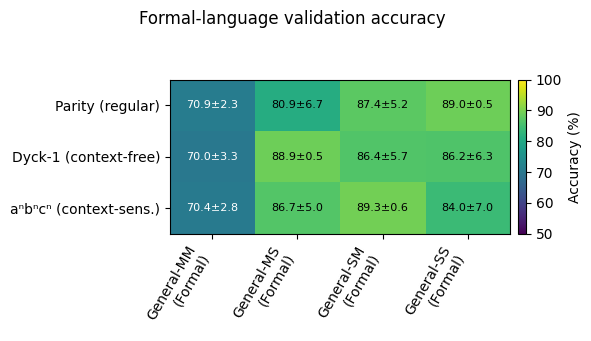

Saved → formal_mm_ms_sm_ss_heatmap.png


In [1]:
# === Formal-language heatmap: MM vs MS vs SM vs SS ============================
# Uses your utils.plotting.plot_formal_heatmaps (row-normalised, 50–100% scale)
from utils.plotting import plot_formal_heatmaps
import numpy as np

# Convert (mean, CI_half) → synthetic 5-run list that yields ~same CI when plotted
def expand_mu_ci(mu, ci, n=5):
    if ci == 0 or np.isnan(mu) or np.isnan(ci):
        return [mu] * n
    s = ci * (n ** 0.5) / 1.96      # CI = 1.96*s/sqrt(n)  -> target sample std
    vals = []
    for _ in range(n // 2):
        vals += [mu + s, mu - s]
    if n % 2:
        vals.append(mu)
    return vals

# Numbers are fractions in [0,1]; CI_half is also a fraction.
# Filled from your heatmaps:
#   SS:  Parity 89.0±0.5%,  Dyck-1 86.2±6.3%,  a^n b^n c^n 84.0±7.0%
#   MM:  Parity 70.9±2.3%,  Dyck-1 70.0±3.3%,  a^n b^n c^n 70.4±2.8%
SS = {
    "Parity (regular)"       : (0.890, 0.005),
    "Dyck-1 (context-free)"  : (0.862, 0.063),
    "aⁿbⁿcⁿ (context-sens.)" : (0.840, 0.070),
}
MM = {
    "Parity (regular)"       : (0.709, 0.023),
    "Dyck-1 (context-free)"  : (0.700, 0.033),
    "aⁿbⁿcⁿ (context-sens.)" : (0.704, 0.028),
}

MS = {
    "Parity (regular)"       : (0.809, 0.067),
    "Dyck-1 (context-free)"  : (0.889, 0.005),
    "aⁿbⁿcⁿ (context-sens.)" : (0.867, 0.050),
}
SM = {
    "Parity (regular)"       : (0.874, 0.052),
    "Dyck-1 (context-free)"  : (0.864, 0.057),
    "aⁿbⁿcⁿ (context-sens.)" : (0.893, 0.006),
}

def to_results_block(d):
    return [
        expand_mu_ci(*d["Parity (regular)"]),
        expand_mu_ci(*d["Dyck-1 (context-free)"]),
        expand_mu_ci(*d["aⁿbⁿcⁿ (context-sens.)"]),
    ]

# Build dict expected by plot_formal_heatmaps; skip any model with NaNs
results_by_model = {}
for name, block in [
    ("General-MM (Formal)", MM),
    ("General-MS (Formal)", MS),
    ("General-SM (Formal)", SM),
    ("General-SS (Formal)", SS),
]:
    vals = np.array([v for k in block for v in block[k]])
    if np.isnan(vals).any():
        print(f"(skip) {name} has NaNs – fill its numbers to include it.")
        continue
    results_by_model[name] = to_results_block(block)

# Draw & save (50–100% color scale like your other plots)
plot_formal_heatmaps(
    results_by_model,
    filename="formal_mm_ms_sm_ss_heatmap.png",
    rotation=60,
    wrap_labels=True,
    figsize_per_model=1.0,
    value_range=(50, 100),
)


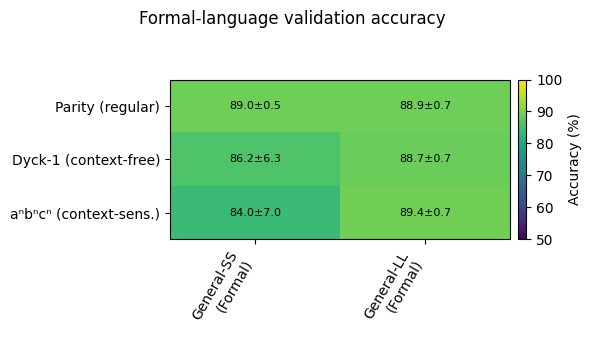

Saved → formal_ablation_SS.png


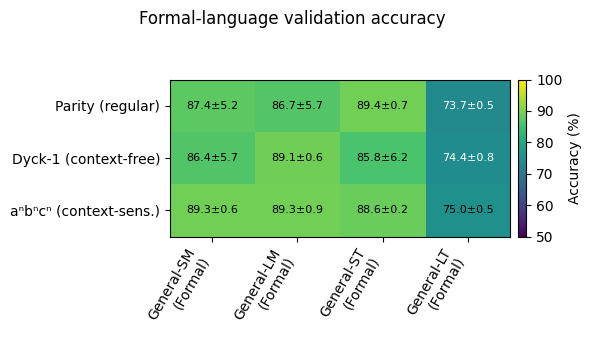

Saved → formal_ablation_SM.png


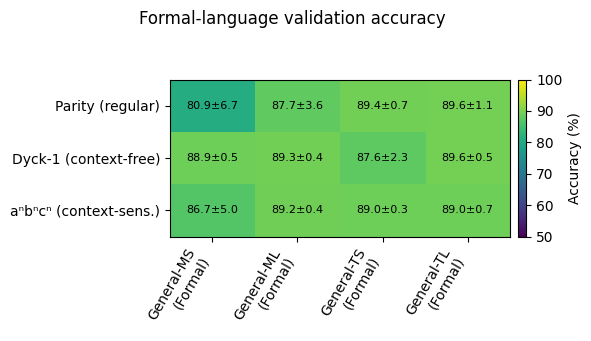

Saved → formal_ablation_MS.png


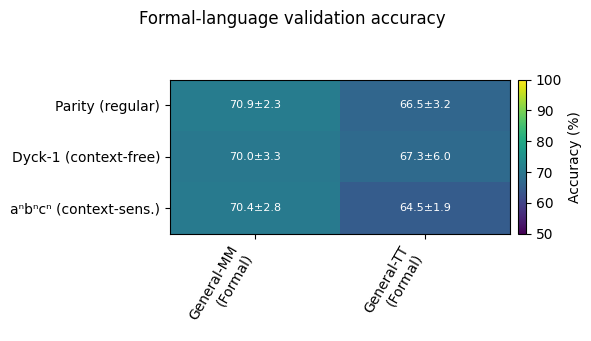

Saved → formal_ablation_MM.png


In [2]:
# === Four ablation heatmaps (SS / SM / MS / MM) ==============================
# Tries your usual import path first
try:
    from utils.plotting import plot_formal_heatmaps
except Exception:
    from plotting import plot_formal_heatmaps

import numpy as np

# Turn (mean, CI_half) into a 5-run list so the plotter will annotate μ±CI
def expand_mu_ci(mu, ci, n=5):
    if ci == 0:
        return [mu] * n
    s = ci * (n ** 0.5) / 1.96
    vals = []
    for _ in range(n // 2):
        vals += [mu + s, mu - s]
    if n % 2:
        vals.append(mu)
    return vals

TASKS = ("Parity (regular)", "Dyck-1 (context-free)", "aⁿbⁿcⁿ (context-sens.)")

def block(means_ci_dict):
    return [
        expand_mu_ci(*means_ci_dict[TASKS[0]]),
        expand_mu_ci(*means_ci_dict[TASKS[1]]),
        expand_mu_ci(*means_ci_dict[TASKS[2]]),
    ]

# -------------------- numbers (fractions) --------------------
SS = {
    "Parity (regular)"       : (0.890, 0.005),
    "Dyck-1 (context-free)"  : (0.862, 0.063),
    "aⁿbⁿcⁿ (context-sens.)" : (0.840, 0.070),
}
LL = {
    "Parity (regular)"       : (0.889, 0.007),
    "Dyck-1 (context-free)"  : (0.887, 0.007),
    "aⁿbⁿcⁿ (context-sens.)" : (0.894, 0.007),
}

SM = {
    "Parity (regular)"       : (0.874, 0.052),
    "Dyck-1 (context-free)"  : (0.864, 0.057),
    "aⁿbⁿcⁿ (context-sens.)" : (0.893, 0.006),
}
LM = {
    "Parity (regular)"       : (0.867, 0.057),
    "Dyck-1 (context-free)"  : (0.891, 0.006),
    "aⁿbⁿcⁿ (context-sens.)" : (0.893, 0.009),
}
ST = {  # from your SM-vs-ST panel
    "Parity (regular)"       : (0.894, 0.007),
    "Dyck-1 (context-free)"  : (0.858, 0.062),
    "aⁿbⁿcⁿ (context-sens.)" : (0.886, 0.002),
}
LT = {
    "Parity (regular)"       : (0.737, 0.005),
    "Dyck-1 (context-free)"  : (0.744, 0.008),
    "aⁿbⁿcⁿ (context-sens.)" : (0.750, 0.005),
}

# For MS ablation, we combine values from MS–TS and MS–ML panels
MS = {
    "Parity (regular)"       : (0.809, 0.067),
    "Dyck-1 (context-free)"  : (0.889, 0.005),
    "aⁿbⁿcⁿ (context-sens.)" : (0.867, 0.050),
}
ML = {
    "Parity (regular)"       : (0.877, 0.036),
    "Dyck-1 (context-free)"  : (0.893, 0.004),
    "aⁿbⁿcⁿ (context-sens.)" : (0.892, 0.004),
}
TS = {
    "Parity (regular)"       : (0.894, 0.007),
    "Dyck-1 (context-free)"  : (0.876, 0.023),
    "aⁿbⁿcⁿ (context-sens.)" : (0.890, 0.003),
}
TL = {
    "Parity (regular)"       : (0.896, 0.011),
    "Dyck-1 (context-free)"  : (0.896, 0.005),
    "aⁿbⁿcⁿ (context-sens.)" : (0.890, 0.007),
}

MM = {
    "Parity (regular)"       : (0.709, 0.023),
    "Dyck-1 (context-free)"  : (0.700, 0.033),
    "aⁿbⁿcⁿ (context-sens.)" : (0.704, 0.028),
}
TT = {
    "Parity (regular)"       : (0.665, 0.032),
    "Dyck-1 (context-free)"  : (0.673, 0.060),
    "aⁿbⁿcⁿ (context-sens.)" : (0.645, 0.019),
}

# -------------------- helpers --------------------
def draw_heatmap(models_dict, outfile):
    plot_formal_heatmaps(
        models_dict,
        filename=outfile,
        rotation=60,
        wrap_labels=True,
        figsize_per_model=1.0,
        value_range=(50, 100),
    )

# -------------------- SS ablation (SS vs LL) --------------------
draw_heatmap({
    "General-SS (Formal)": block(SS),
    "General-LL (Formal)": block(LL),
}, "formal_ablation_SS.png")

# -------------------- SM ablation (SM, LM, ST, LT) --------------
draw_heatmap({
    "General-SM (Formal)": block(SM),
    "General-LM (Formal)": block(LM),
    "General-ST (Formal)": block(ST),
    "General-LT (Formal)": block(LT),
}, "formal_ablation_SM.png")

# -------------------- MS ablation (MS, ML, TS, TL) --------------
draw_heatmap({
    "General-MS (Formal)": block(MS),
    "General-ML (Formal)": block(ML),
    "General-TS (Formal)": block(TS),
    "General-TL (Formal)": block(TL),
}, "formal_ablation_MS.png")

# -------------------- MM ablation (MM vs TT) --------------------
draw_heatmap({
    "General-MM (Formal)": block(MM),
    "General-TT (Formal)": block(TT),
}, "formal_ablation_MM.png")


In [21]:
# --- compact one-row figure (fixed spacing + short labels) --------------------
import matplotlib.pyplot as plt
import numpy as np

SHORT = {
    "General-SS (Formal)":"SS","General-LL (Formal)":"LL",
    "General-SM (Formal)":"SM","General-LM (Formal)":"LM",
    "General-ST (Formal)":"ST","General-LT (Formal)":"LT",
    "General-MS (Formal)":"MS","General-ML (Formal)":"ML",
    "General-TS (Formal)":"TS","General-TL (Formal)":"TL",
    "General-MM (Formal)":"MM","General-TT (Formal)":"TT",
}

def _mean_ci(vals):
    vals = np.asarray(vals, float)
    if vals.ndim == 0 or len(vals) <= 1:
        return float(np.mean(vals)), 0.0
    mu = float(np.mean(vals))
    ci = 1.96 * float(np.std(vals, ddof=1)) / (len(vals) ** 0.5)
    return mu, ci

def _heatmap_on_ax(ax, results_by_model, *, rotation=45, value_range=(50, 100)):
    tasks = ["Parity (regular)", "Dyck-1 (context-free)", "aⁿbⁿcⁿ (context-sens.)"]
    models = list(results_by_model.keys())
    xticks = [SHORT.get(m, m) for m in models]

    data, annot = [], []
    for t in range(3):
        row_vals, row_ann = [], []
        for m in models:
            v = results_by_model[m][t]
            mu, ci = _mean_ci(v if isinstance(v, (list, tuple, np.ndarray)) else [v])
            mu_p, ci_p = mu*100, ci*100
            row_vals.append(mu_p)
            row_ann.append(f"{mu_p:.1f}" if ci_p == 0 else f"{mu_p:.1f}±{ci_p:.1f}")
        data.append(row_vals); annot.append(row_ann)
    data = np.asarray(data)

    im = ax.imshow(data, aspect="auto", cmap="viridis",
                   vmin=value_range[0], vmax=value_range[1])

    ax.set_xticks(np.arange(len(models))); ax.set_xticklabels(xticks, rotation=rotation, ha="right", fontsize=9)
    ax.set_yticks(np.arange(3)); ax.set_yticklabels(tasks, fontsize=9)

    mid = sum(value_range)/2
    for i in range(3):
        for j in range(len(models)):
            ax.text(j, i, annot[i][j], ha="center", va="center",
                    color="white" if data[i, j] < mid else "black", fontsize=8)
    return im

def draw_all_four_in_one_row(panels, outfile="formal_ablation_all_in_one_row.png",
                             value_range=(50, 100)):
    width_ratios = [max(2, len(md)) for _, md in panels]
    fig_w = max(14, 0.95 * sum(width_ratios))
    fig, axes = plt.subplots(
        1, 4, figsize=(fig_w, 4.0),
        gridspec_kw={"width_ratios": width_ratios, "wspace": 0.10},
        constrained_layout=True
    )

    last_im = None
    for i, (ax, (title, md)) in enumerate(zip(axes, panels)):
        im = _heatmap_on_ax(ax, md, rotation=45, value_range=value_range)
        ax.set_title(title, fontsize=12, pad=16)
        if i != 0:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        last_im = im

    cbar = fig.colorbar(last_im, ax=axes.ravel().tolist(), pad=0.01, fraction=0.03)
    cbar.set_label("Accuracy (%)", fontsize=11)
    fig.suptitle("Formal-language ablations (mean ± 95% CI over 5 runs)", y=1.06, fontsize=12)
    fig.show()
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    fig.savefig(outfile.replace(".png", ".pdf"), bbox_inches="tight")  # vector for LaTeX
    
    print("Saved →", outfile, "and PDF.")


C:\Users\Medo\AppData\Local\Temp\ipykernel_37876\3255819156.py:74: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved → formal_ablation_all_in_one_row.png and PDF.


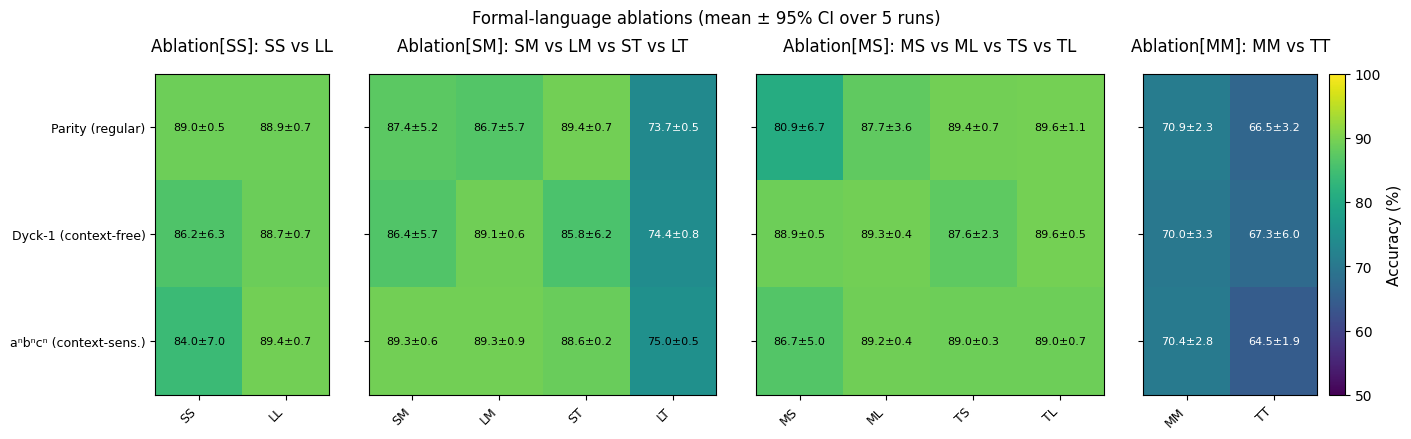

In [22]:
panels = [
    ("Ablation[SS]: SS vs LL", {
        "General-SS (Formal)": block(SS),
        "General-LL (Formal)": block(LL),
    }),
    ("Ablation[SM]: SM vs LM vs ST vs LT", {
        "General-SM (Formal)": block(SM),
        "General-LM (Formal)": block(LM),
        "General-ST (Formal)": block(ST),
        "General-LT (Formal)": block(LT),
    }),
    ("Ablation[MS]: MS vs ML vs TS vs TL", {
        "General-MS (Formal)": block(MS),
        "General-ML (Formal)": block(ML),
        "General-TS (Formal)": block(TS),
        "General-TL (Formal)": block(TL),
    }),
    ("Ablation[MM]: MM vs TT", {
        "General-MM (Formal)": block(MM),
        "General-TT (Formal)": block(TT),
    }),
]
draw_all_four_in_one_row(panels, "formal_ablation_all_in_one_row.png")


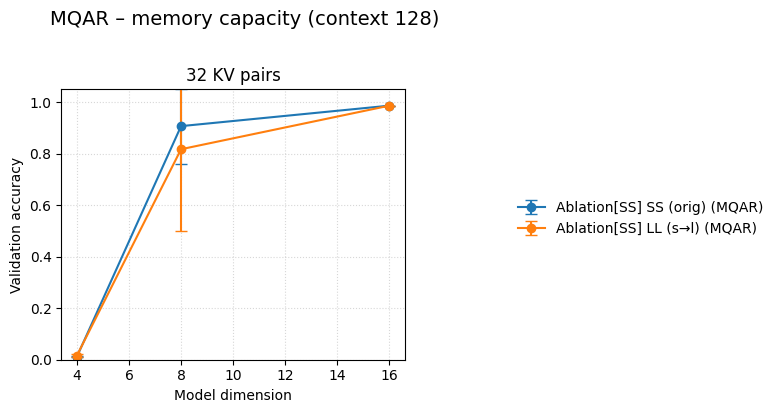

Saved → results/mqar_capacity_panels\mqar_ablation_SS_N128.png


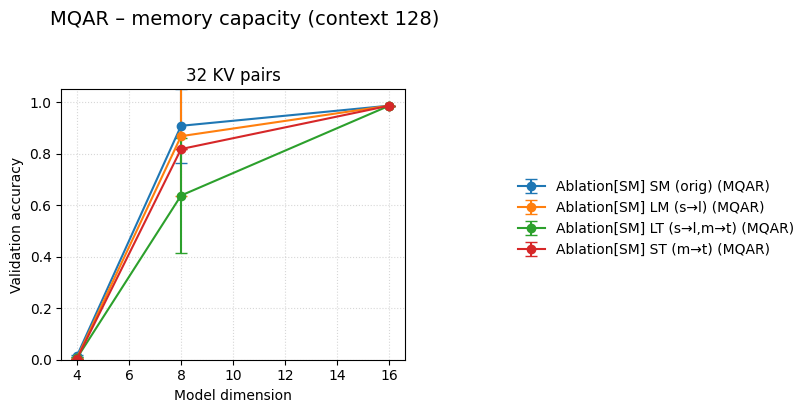

Saved → results/mqar_capacity_panels\mqar_ablation_SM_N128.png


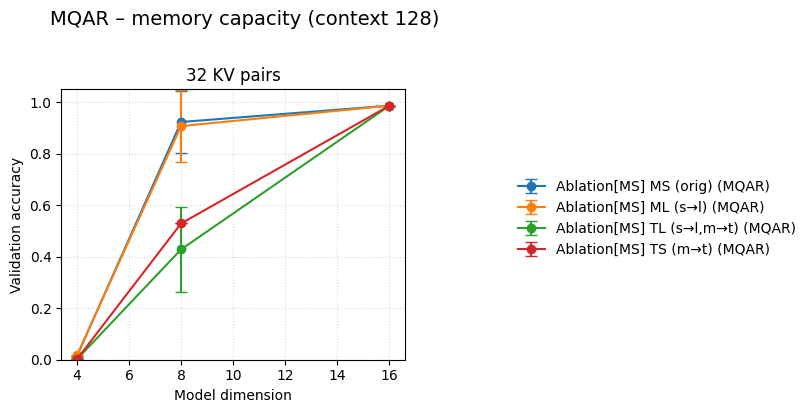

Saved → results/mqar_capacity_panels\mqar_ablation_MS_N128.png


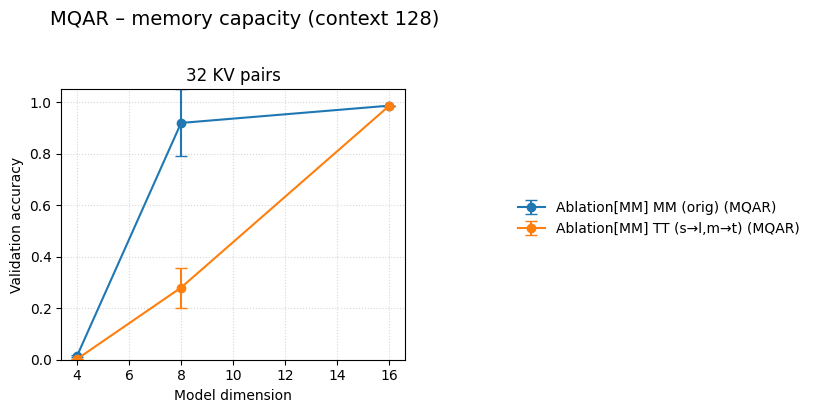

Saved → results/mqar_capacity_panels\mqar_ablation_MM_N128.png


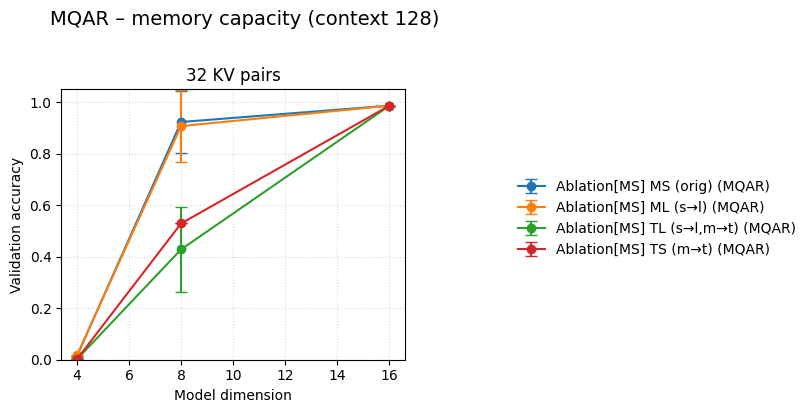

Saved → results/mqar_capacity_panels\mqar_MS_combinations_N128.png
Done.


In [4]:
# ======================================================================
# MQAR capacity panels — load saved JSONs and plot triads
#   - expects JSONs saved by sweep_mqar_capacity(...)
#   - produces 5 figures:
#       * mqar_MS_combinations_N{seq_len}.png
#       * mqar_ablation_SS_N{seq_len}.png
#       * mqar_ablation_SM_N{seq_len}.png
#       * mqar_ablation_MS_N{seq_len}.png
#       * mqar_ablation_MM_N{seq_len}.png
# ======================================================================
import os, json, re
from typing import Dict, List, Union, Iterable, Optional

# your plotting helper
try:
    from utils.plotting import plot_mqar_capacity_panels
except Exception:
    from plotting import plot_mqar_capacity_panels

# ---------------- config (match what you ran) ----------------
RESULTS_ROOTS = [
    "results/xlstm_ablation_combined",     # if you used combine_saved_results_for_plot
    "results/xlstm_ablation",              # original ablation
    "results/xlstm_ablation_st_ts_only",   # extra ST/TS
]
SEQ_LEN   = 128
TRAIN_SZ  = 20_000
VAL_SZ    = 3_000
SAVE_DIR  = "results/mqar_capacity_panels"     # where to save the new panels
os.makedirs(SAVE_DIR, exist_ok=True)

SUMMARY_NAME = f"summary_N{SEQ_LEN}_train{TRAIN_SZ}_val{VAL_SZ}.json"

# ---------------- utilities ----------------
def _load_summary(path: str) -> Optional[Dict]:
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def _merge_results(dst: Dict, src: Dict) -> Dict:
    """
    Merge src into dst. JSON keys are strings → cast to int for kv and width.
    Structure: { kv : { model : { width : [acc, ...] } } }
    """
    for kv_str, panel in src.items():
        kv = int(kv_str)
        for model, w2acc in panel.items():
            for w_str, vals in w2acc.items():
                w = int(w_str)
                dst.setdefault(kv, {}).setdefault(model, {}).setdefault(w, []).extend(vals)
    return dst

def load_all_results(results_roots: Iterable[str], summary_name: str) -> Dict[int, Dict[str, Dict[int, List[float]]]]:
    merged: Dict[int, Dict[str, Dict[int, List[float]]]] = {}
    # prefer an already-combined folder if present
    for root in results_roots:
        path = os.path.join(root, summary_name)
        data = _load_summary(path)
        if data is not None:
            _merge_results(merged, data)
    if not merged:
        raise FileNotFoundError(
            f"No summaries found. Looked for {summary_name} under:\n  - " +
            "\n  - ".join(results_roots)
        )
    return merged

def _filter_by_models(results_by_kv: Dict, keep_models: Iterable[str]) -> Dict:
    """Return a copy of results_by_kv keeping only models in keep_models."""
    keep = set(keep_models)
    sub = {}
    for kv, panel in results_by_kv.items():
        filtered = {m: panel[m] for m in panel if m in keep}
        if filtered:
            sub[kv] = filtered
    return sub

def _models_for_base(results_by_kv: Dict, base: str) -> List[str]:
    """
    Collect model names whose label contains Ablation[BASE].
    Example names: 'Ablation[SM] SM (orig) (MQAR)', 'Ablation[MS] TL (l→t) (MQAR)'
    """
    any_kv = next(iter(results_by_kv))
    names = list(results_by_kv[any_kv].keys())
    pat = re.compile(rf"Ablation\[{re.escape(base)}\]\s+")
    return [n for n in names if pat.search(n)]

# ---------------- load + plot ----------------
results = load_all_results(RESULTS_ROOTS, SUMMARY_NAME)

# Ablation triads: SS, SM, MS, MM
for base in ("SS", "SM", "MS", "MM"):
    models = _models_for_base(results, base)
    sub = _filter_by_models(results, models)
    out_path = os.path.join(SAVE_DIR, f"mqar_ablation_{base}_N{SEQ_LEN}.png")
    plot_mqar_capacity_panels(sub, context_len=SEQ_LEN, save_path=out_path)

# Extra: MS combinations panel (MS, ML, TS, TL) as a single figure
# (This is essentially the same as the ablation MS figure, but kept separate per your request.)
ms_models = _models_for_base(results, "MS")
ms_sub = _filter_by_models(results, ms_models)
plot_mqar_capacity_panels(ms_sub, context_len=SEQ_LEN,
                          save_path=os.path.join(SAVE_DIR, f"mqar_MS_combinations_N{SEQ_LEN}.png"))

print("Done.")


C:\Users\Medo\AppData\Local\Temp\ipykernel_44788\582242352.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


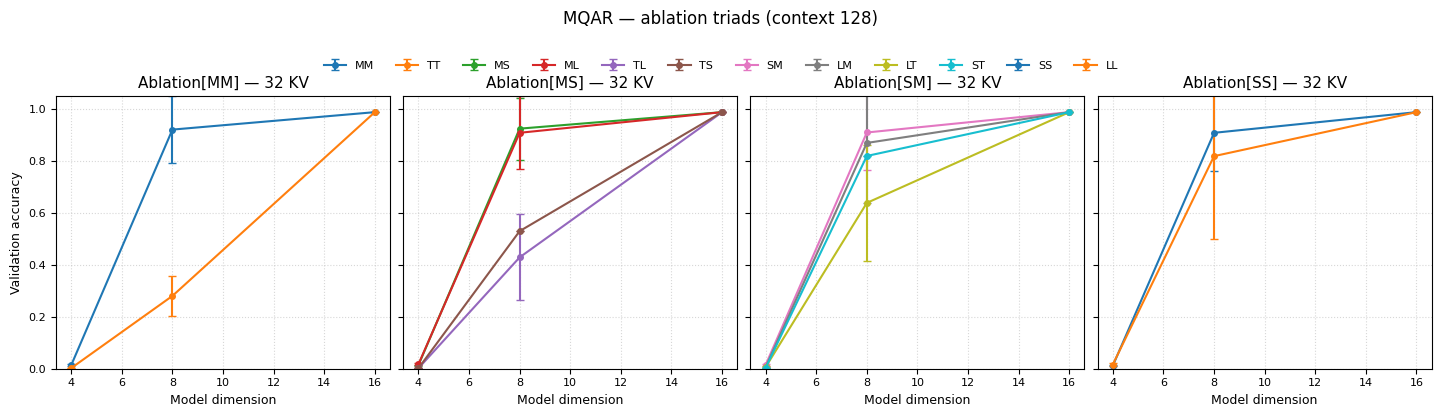

Saved → results/mqar_compact_panels\mqar_ablation_row_MM_MS_SM_SS_N128.png


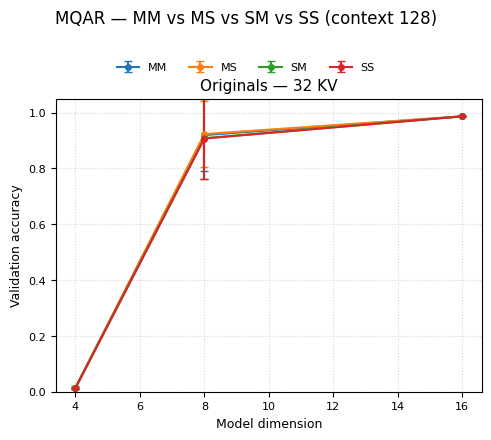

Saved → results/mqar_compact_panels\mqar_bases_MM_MS_SM_SS_N128.png


In [9]:
# =============================================================================
# MQAR compact plots
#   • 1×4 row: Ablations for MM | MS | SM | SS (triads)
#   • Single panel: Originals only → MM vs MS vs SM vs SS
# =============================================================================
import os, json, re
from typing import Dict, Iterable, List, Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

# ---------------- config (match your run grid) ----------------
RESULTS_ROOTS = [
    "results/xlstm_ablation_combined",   # if you ran combine_saved_results_for_plot
    "results/xlstm_ablation",            # original ablation
    "results/xlstm_ablation_st_ts_only", # extra ST/TS (optional)
]
SEQ_LEN  = 128
TRAIN_SZ = 20_000
VAL_SZ   = 3_000
SUMMARY  = f"summary_N{SEQ_LEN}_train{TRAIN_SZ}_val{VAL_SZ}.json"

SAVE_DIR = "results/mqar_compact_panels"
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------- utils: load + merge ----------------
def _load_summary(path: str) -> Optional[Dict]:
    if not os.path.exists(path): return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def _merge(dst: Dict, src: Dict) -> Dict:
    # {kv: {model: {width: [acc,…]}}}
    for kv_str, panel in src.items():
        kv = int(kv_str)
        for model, w2v in panel.items():
            for w_str, vals in w2v.items():
                w = int(w_str)
                dst.setdefault(kv, {}).setdefault(model, {}).setdefault(w, []).extend(vals)
    return dst

def load_all(results_roots: Iterable[str], summary_name: str) -> Dict[int, Dict[str, Dict[int, List[float]]]]:
    merged = {}
    for root in results_roots:
        p = os.path.join(root, summary_name)
        data = _load_summary(p)
        if data: _merge(merged, data)
    if not merged:
        raise FileNotFoundError(
            f"Could not find {summary_name} under:\n  - " + "\n  - ".join(results_roots)
        )
    return merged

# ---------------- utils: grouping + labels ----------------
BASES = ("MM", "MS", "SM", "SS")  # requested left→right order

def short_label(full: str) -> str:
    # Prefer the explicit two-letter variant after the ablation tag, e.g. “…] TL …” → "TL"
    m = re.search(r"Ablation\[[A-Z]{2}\]\s+([A-Z]{2})", full)
    if m: return m.group(1)
    m = re.search(r"General-([A-Z]{2})", full)
    if m: return m.group(1)
    m = re.search(r"\b([A-Z]{2})\b", full)
    return m.group(1) if m else full

def is_for_base(model_name: str, base: str) -> bool:
    return re.search(rf"Ablation\[{base}\]", model_name) is not None

def is_original(model_name: str) -> bool:
    return "(orig)" in model_name

def mean_ci(values: List[float]) -> Tuple[float, float]:
    a = np.asarray(values, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0: return 0.0, 0.0
    if a.size == 1: return float(a[0]), 0.0
    m = float(np.mean(a))
    s = float(np.std(a, ddof=1))
    return m, 1.96 * s / np.sqrt(a.size)

# ---------------- drawing primitives -----------------------------------------
def collect_colors(labels: List[str]):
    cmap = plt.cm.get_cmap('tab10')
    uniq = list(dict.fromkeys(labels))  # preserve first-seen order
    return {lab: cmap(i % 10) for i, lab in enumerate(uniq)}

def draw_capacity_panel(ax, panel_dict: Dict[str, Dict[int, List[float]]],
                        model2color, title: str, show_ylabel: bool):
    for model_name, width2vals in panel_dict.items():
        lab = short_label(model_name)
        widths = sorted(width2vals.keys())
        means, errs = [], []
        for w in widths:
            vals = width2vals[w]
            mu, ci = (mean_ci(vals) if isinstance(vals, (list, tuple)) else (float(vals), 0.0))
            means.append(mu); errs.append(ci)
        ax.errorbar(widths, means, yerr=errs,
                    color=model2color[lab], marker='o', capsize=3, lw=1.5,
                    markersize=4, label=lab)
    ax.set_title(title, fontsize=11, pad=6)
    ax.set_xlabel("Model dimension", fontsize=9)
    if show_ylabel: ax.set_ylabel("Validation accuracy", fontsize=9)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle=':', alpha=.5)
    ax.tick_params(labelsize=8)

# ---------------- main: load, slice, and plot --------------------------------
results = load_all(RESULTS_ROOTS, SUMMARY)
kv = sorted(results.keys())[0]  # typically a single KV (e.g., 32)

# Build per-base panels (keep whatever is present for that base)
panels_by_base: Dict[str, Dict[str, Dict[int, List[float]]]] = {b:{} for b in BASES}
for model_name, width2vals in results[kv].items():
    for base in BASES:
        if is_for_base(model_name, base):
            panels_by_base[base][model_name] = width2vals

# ---- Figure A: 4 ablation triads on one row (MM | MS | SM | SS) -------------
# One skinny legend across the row, colors shared by short two-letter labels
all_labels = [short_label(n) for b in BASES for n in panels_by_base[b].keys()]
color_map = collect_colors(all_labels)

fig, axes = plt.subplots(1, 4, figsize=(14.3, 3.4), sharey=True, constrained_layout=True)
for i, base in enumerate(BASES):
    draw_capacity_panel(
        axes[i],
        panels_by_base[base],
        color_map,
        title=f"Ablation[{base}] — {kv} KV",
        show_ylabel=(i == 0)
    )

# Single slim legend above
handles, labels = [], []
seen = set()
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in seen:
            seen.add(ll); handles.append(hh); labels.append(ll)
fig.legend(handles, labels, loc="upper center", ncol=min(len(labels), 12),
           bbox_to_anchor=(0.5, 1.06), fontsize=8, frameon=False)
fig.suptitle(f"MQAR — ablation triads (context {SEQ_LEN})", y=1.18, fontsize=12)

out_row = os.path.join(SAVE_DIR, f"mqar_ablation_row_MM_MS_SM_SS_N{SEQ_LEN}.png")
fig.savefig(out_row, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved →", out_row)

# ---- Figure B: Originals-only comparison (MM vs MS vs SM vs SS) -------------
orig_panel = {}
for base in BASES:
    # find the single “… base (orig) …” model for this base
    for name, w2v in panels_by_base[base].items():
        if is_original(name):
            orig_panel[name] = w2v
            break

if not orig_panel:
    raise RuntimeError("No '(orig)' models found. Did you run the ablation sweep?")

# Compact single-axes plot with a small legend
fig2, ax2 = plt.subplots(1, 1, figsize=(4.8, 3.6), constrained_layout=True)
# Force a consistent label order in legend: MM, MS, SM, SS
ordered_names = []
for base in BASES:
    for n in orig_panel:
        if short_label(n) == base:
            ordered_names.append(n)
# draw
ordered_panel = {n: orig_panel[n] for n in ordered_names}
base_colors = collect_colors([short_label(n) for n in ordered_names])

draw_capacity_panel(ax2, ordered_panel, base_colors, f"Originals — {kv} KV", show_ylabel=True)
h2, l2 = ax2.get_legend_handles_labels()
fig2.legend(h2, l2, loc="upper center", ncol=len(l2), bbox_to_anchor=(0.5, 1.06),
            fontsize=8, frameon=False)
fig2.suptitle(f"MQAR — MM vs MS vs SM vs SS (context {SEQ_LEN})", y=1.18, fontsize=12)

out_bases = os.path.join(SAVE_DIR, f"mqar_bases_MM_MS_SM_SS_N{SEQ_LEN}.png")
fig2.savefig(out_bases, dpi=150, bbox_inches="tight")
plt.show()
plt.close(fig2)
print("Saved →", out_bases)


In [15]:
# === Print MQAR numbers for ALL models (not just LL/TT) ======================
# Reads results/* JSONs, aggregates repetitions, prints mean ± 95% CI in %.

import os, re, glob, json, math
import numpy as np

# ---- where to look -----------------------------------------------------------
RESULTS_ROOTS = [
    "results/xlstm_ablation",
    "results/xlstm_ablation_ss",
    "results/xlstm_ablation_mm",
    "results/xlstm_ablation_sm",
    "results/xlstm_ablation_ms",
    "results/mm_vs_tt",
    "results/tl_two_block_combinations",
]

KV_TARGET = None   # set =32 if you want only KV=32, or None for all

# ---- helpers ----------------------------------------------------------------
def merge(dst, src):
    # shape: {kv: {model: {width: [accs...]}}}
    for kv, md in src.items():
        for name, wdict in md.items():
            for w, vals in wdict.items():
                dst.setdefault(kv, {}).setdefault(name, {}).setdefault(w, [])
                dst[kv][name][w].extend(vals)

def load_summary(path):
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    out = {}
    for kv, md in raw.items():
        kv_i = int(kv)
        out.setdefault(kv_i, {})
        for name, wdict in md.items():
            out[kv_i].setdefault(name, {})
            for w, vals in wdict.items():
                out[kv_i][name][int(w)] = list(vals)
    return out

def load_perrun(path):
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)
    name = obj.get("model_name", "")
    run  = obj.get("run", {})
    kv   = run.get("kv_pairs")
    width= run.get("embed_dim")
    acc  = obj.get("best", {}).get("val_acc")
    try:
        kv_i    = int(kv)
        width_i = int(width)
        acc_f   = float(acc)
    except Exception:
        return {}
    if not math.isfinite(acc_f):
        return {}
    return {kv_i: {name: {width_i: [acc_f]}}}

def harvest_all():
    res = {}
    # summaries
    for root in RESULTS_ROOTS:
        for p in glob.glob(os.path.join(root, "summary_*.json")):
            try: merge(res, load_summary(p))
            except Exception: pass
    # per-run jsons
    for root in RESULTS_ROOTS:
        for p in glob.glob(os.path.join(root, "*.json")):
            if os.path.basename(p).startswith("summary_"): 
                continue
            try: merge(res, load_perrun(p))
            except Exception: pass
    return res

def mean_ci(vals):
    arr = np.array(vals, dtype=float)
    mu = float(arr.mean()) if arr.size else float("nan")
    if arr.size >= 2:
        ci = 1.96 * arr.std(ddof=1) / np.sqrt(arr.size)
    else:
        ci = 0.0
    return mu, ci

# ---- run --------------------------------------------------------------------
all_results = harvest_all()

kvs = [KV_TARGET] if KV_TARGET is not None else sorted(all_results.keys())

for kv in kvs:
    if kv not in all_results:
        continue
    print(f"\nMQAR @ KV={kv} — mean ± 95% CI (percent)\n")
    for model in sorted(all_results[kv].keys()):
        wdict = all_results[kv][model]
        widths = sorted(wdict.keys())
        line_parts = []
        for w in widths:
            mu, ci = mean_ci(wdict[w])
            if math.isnan(mu): continue
            line_parts.append(f"d={w}: {mu*100:.1f}±{ci*100:.1f}")
        if line_parts:
            print(f"{model}:")
            print("  " + " · ".join(line_parts))



MQAR @ KV=16 — mean ± 95% CI (percent)

Ablation[SM] LM (s→l) (MQAR):
  d=4: 0.6±0.0
Ablation[SM] LT (s→l,m→t) (MQAR):
  d=4: 0.1±0.0
Ablation[SM] SM (orig) (MQAR):
  d=4: 0.7±0.0
Ablation[SS] LL (s→l) (MQAR):
  d=4: 0.2±0.0
Ablation[SS] SS (orig) (MQAR):
  d=4: 0.4±0.0

MQAR @ KV=32 — mean ± 95% CI (percent)

Ablation[MM] MM (orig) (MQAR):
  d=4: 1.3±0.2 · d=8: 92.0±8.8 · d=16: 98.7±0.0
Ablation[MM] TT (s→l,m→t) (MQAR):
  d=4: 0.2±0.1 · d=8: 28.0±5.2 · d=16: 98.7±0.0
Ablation[MS] ML (s→l) (MQAR):
  d=4: 1.7±0.2 · d=8: 90.7±9.4 · d=16: 98.7±0.0
Ablation[MS] MS (orig) (MQAR):
  d=4: 1.4±0.1 · d=8: 92.3±8.0 · d=16: 98.7±0.0
Ablation[MS] TL (s→l,m→t) (MQAR):
  d=4: 0.2±0.0 · d=8: 42.8±11.1 · d=16: 98.6±0.0
Ablation[SM] LM (s→l) (MQAR):
  d=4: 0.6±0.1 · d=8: 86.8±15.6 · d=16: 98.7±0.0
Ablation[SM] LT (s→l,m→t) (MQAR):
  d=4: 0.6±0.2 · d=8: 63.8±15.1 · d=16: 98.7±0.0
Ablation[SM] SM (orig) (MQAR):
  d=4: 1.4±0.3 · d=8: 90.8±9.8 · d=16: 98.7±0.0
Ablation[SS] LL (s→l) (MQAR):
  d=4: 1.6±0.5 

In [6]:
echo CUDA_HOME

CUDA_HOME


In [1]:
!export TORCH_CUDA_ARCH_LIST="8.0;8.6;9.0"


'export' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import os
os.environ["CUDA_HOME"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1"
os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"
print(os.getenv("TORCH_CUDA_ARCH_LIST"))



8.9


In [1]:
import shutil, pathlib

cache = pathlib.Path.home() / ".cache" / "torch_extensions"
for folder in cache.glob("xlstm*"):
    shutil.rmtree(folder, ignore_errors=True)
for folder in cache.glob("slstm*"):
    shutil.rmtree(folder, ignore_errors=True)

In [2]:
import os
os.environ["TORCH_CPP_BUILD_VERBOSE"] = "1"
os.environ["VERBOSE"] = "1"
os.environ["MAX_JOBS"] = "1"

In [3]:
import os, subprocess, sys
print("ARCH:", os.getenv("TORCH_CUDA_ARCH_LIST"))
print("CUDA_HOME:", os.getenv("CUDA_HOME"))
# sanity: invoke nvcc quickly to see the same env in a child proc
subprocess.run(["nvcc", "--version"])


ARCH: 8.9
CUDA_HOME: C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1


CompletedProcess(args=['nvcc', '--version'], returncode=0)

In [1]:
# #1

# import os
# os.environ["CUDA_HOME"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1"
# os.environ["TORCH_CUDA_ARCH_LIST"] = "8.9"
# print(os.getenv("TORCH_CUDA_ARCH_LIST"))
# #2
# import shutil, pathlib

# cache = pathlib.Path.home() / ".cache" / "torch_extensions"
# for folder in cache.glob("xlstm*"):
#     shutil.rmtree(folder, ignore_errors=True)
# for folder in cache.glob("slstm*"):
#     shutil.rmtree(folder, ignore_errors=True)
# #3
# import os
# os.environ["TORCH_CPP_BUILD_VERBOSE"] = "1"
# os.environ["VERBOSE"] = "1"
# os.environ["MAX_JOBS"] = "1"
# #4
# import os, subprocess, sys
# print("ARCH:", os.getenv("TORCH_CUDA_ARCH_LIST"))
# print("CUDA_HOME:", os.getenv("CUDA_HOME"))
# # sanity: invoke nvcc quickly to see the same env in a child proc
# subprocess.run(["nvcc", "--version"])
# #5
# import shutil, pathlib, os
# cache = pathlib.Path.home() / ".cache" / "torch_extensions"
# for p in cache.glob("xlstm*"): shutil.rmtree(p, ignore_errors=True)
# for p in cache.glob("slstm*"): shutil.rmtree(p, ignore_errors=True)


# import shutil, pathlib
# cache = pathlib.Path.home() / ".cache" / "torch_extensions"
# for folder in cache.glob("slstm*"):
#     shutil.rmtree(folder, ignore_errors=True)

from xlstm import xLSTMBlockStack, xLSTMBlockStackConfig, sLSTMBlockConfig, sLSTMLayerConfig

cfg = xLSTMBlockStackConfig(
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(backend="cuda", num_heads=4)),
    embedding_dim=128,
    context_length=256,
    num_blocks=2
)
stack = xLSTMBlockStack(cfg)  # <-- triggers compilation


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-LC:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.4\\lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -

RuntimeError: Error building extension 'slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0'

In [ ]:
import torch

from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=256,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],

)

xlstm_stack = xLSTMBlockStack(cfg)

x = torch.randn(4, 256, 128).to("cuda")
xlstm_stack = xlstm_stack.to("cuda")
y = xlstm_stack(x)
y.shape == x.shape

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['/LIBPATH:C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.1\\lib', 'cublas.lib'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas', '-v', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', 

Using C:\Users\moham\AppData\Local\torch_extensions\torch_extensions\Cache\py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\moham\AppData\Local\torch_extensions\torch_extensions\Cache\py312_cu121\slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0\build.ninja...
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Using envvar MAX_JOBS (1) as the number of workers...


RuntimeError: Error building extension 'slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0'

In [5]:
import torch

from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

cfg = xLSTMBlockStackConfig(
    mlstm_block=mLSTMBlockConfig(
        mlstm=mLSTMLayerConfig(
            conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
        )
    ),
    slstm_block=sLSTMBlockConfig(
        slstm=sLSTMLayerConfig(
            backend="cuda",
            num_heads=4,
            conv1d_kernel_size=4,
            bias_init="powerlaw_blockdependent",
        ),
        feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
    ),
    context_length=256,
    num_blocks=7,
    embedding_dim=128,
    slstm_at=[1],

)

xlstm_stack = xLSTMBlockStack(cfg)

x = torch.randn(4, 256, 128).to("cuda")
xlstm_stack = xlstm_stack.to("cuda")
y = xlstm_stack(x)
y.shape == x.shape

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['/LIBPATH:C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.1\\lib', 'cublas.lib'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=128', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas', '-v', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', 

Using C:\Users\moham\AppData\Local\torch_extensions\torch_extensions\Cache\py312_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file C:\Users\moham\AppData\Local\torch_extensions\torch_extensions\Cache\py312_cu121\slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0\build.ninja...
Building extension module slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Using envvar MAX_JOBS (1) as the number of workers...


RuntimeError: Error building extension 'slstm_HS128BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0'

In [4]:
import xlstm
